# Exploratory Data Analysis of Powercreep in Pokemon

Original dataset taken from Josh Korngiebel on Kaggle.
https://www.kaggle.com/datasets/jkorn28/pokemon-stats-gens-1-9 

Dataset modified by me in the data prep folder. All operations in this notebook will be using the modified csv file.

## <h1 style="text-align: center;">Introduction</h1>

### **Background**

Standing head and shoulders over every single media company and intellectual property group in the world is Pokemon. As the highest grossing media franchise of all time, Pokemon has cemented, no matter how big or small, a place in the minds of almost everyone. Because of the many games and multiplayer features added, communities of hobbyists dedicated to competitive Pokemon battling have developed. 

These hobbyists have developed remarkably optimized Pokemon teams, and continue to battle online with a thriving competitive scene. Everytime a new generation of Pokemon is released, the online competitive scene has to scramble to adjust to what has been deemed "powercreep". Powercreep is a term used throughout gaming to generally refer to the phenomenon of new > old, that is, new content released by the maker of the game more often than not tend to outclass older content.

### **Goal**

Leveraging Python libraries, we hope to both quantify and visualize the effect of powercreep. This will be done by analyzing the inclusion of certain factors that tend to increase the power level of Pokemon by generation. Or, in the case that no clear distinction is shown by broad analysis, check to see if there is noticeable powercreep to begin with.

## <h1 style="text-align: center;">Table of Contents</h1>

1. The Data
    - Loading
    - Previewing & Explaining
        - Relevance
    - Error Testing
        - The Extreme Outlier
        - Suspicious Stats
        - Type Testing
1. Analysis
    - Smogon Usage
        - Usage Breakdown Across Tiers
    - Stat Distributions
        - Generational Averages and Medians
    - Type Strength
        - Offensive
        - Defensive
    - Special Pokemon
        - Legendaries
        - Mythicals
        - Notables
        - "Optimized" Pokemon
1. Conclusions
    

## <h1 style="text-align: center;">The Data</h1>

### **Loading (+ Libraries)**

In [441]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from itertools import combinations

In [442]:
pokedf = pd.read_csv('pokemon_data_custom.csv')

The data has already been prepared in another folder on this repository. For more detailed information on what changes were made to the original dataset by Josh Korngiebel, refer to that folder. Briefly, useful columns were added for classification, and 7 missing Pokemon were added.

### **Previewing & Explaining**

In [443]:
pokedf.head()

,Dex No,Name,Base Name,Type 1,Type 2,BST,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Generation,Legendary,Mythical,Notable
0,1,Bulbasaur,Bulbasaur,GRASS,POISON,318,45,49,49,65,65,45,1,False,False,False
1,2,Ivysaur,Ivysaur,GRASS,POISON,405,60,62,63,80,80,60,1,False,False,False
2,3,Venusaur,Venusaur,GRASS,POISON,525,80,82,83,100,100,80,1,False,False,False
3,3,Mega Venusaur,Venusaur,GRASS,POISON,625,80,100,123,122,120,80,1,False,False,False
4,4,Charmander,Charmander,FIRE,-,309,39,52,43,60,50,65,1,False,False,False


In [444]:
pokedf.tail()

,Dex No,Name,Base Name,Type 1,Type 2,BST,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Generation,Legendary,Mythical,Notable
1196,1013,Sinistcha,Sinistcha,GRASS,GHOST,508,71,60,106,121,80,70,9,False,False,False
1197,1014,Okidogi,Okidogi,POISON,FIGHTING,555,88,128,115,58,86,80,9,True,False,False
1198,1015,Munkidori,Munkidori,POISON,PSYCHIC,555,88,75,66,130,90,106,9,True,False,False
1199,1016,Fezandipiti,Fezandipiti,POISON,FAIRY,555,88,91,82,70,125,99,9,True,False,False
1200,1017,Ogerpon,Ogerpon,GRASS,-,550,80,120,84,60,96,110,9,True,False,False


The data contains 16 columns.
- Dex No: Refers to the official *Pokedex* number, of the Pokemon. Every Pokemon has a unique Pokedex number, or as it will be referred to, Dex number.

- Name: Self explanatory with one caveat, certain Pokemon are considered *alternate forms*, that is, they are the same species of Pokemon, but simply a different variant. One example is the Mega Venusaur visible in the dataframe head. Notice the entry shares the same Dex number as its base form, Venusaur.

- Base Name: Every Pokemon has the same Base Name as Name, except the aformentioned variants, who instead have the name of the original form.

- Type 1 and 2: There are 18 elemental "types" of Pokemon, which will be explained in more detail later. Notice that not all Pokemon have two types, some only have one. In that case, the Type 2 column will have a placeholder '-'.

- BST, HP, Attack, Defense, Sp. Attack, Sp. Defense, and Speed: HP through Speed all refer to different stats of a Pokemon. "Sp" in two of the columns stands for "Special" which just refers to a slightly different but equally important Attack and Defense stat. "HP" stands for "Health Points". BST is simply the total of these six fundamental stats. Note that higher = better when it comes to stats.

- Generation: Pokemon are released not one by one, but in large batches, referred to as "Generations", or more colloquially, just "Gens". There are currently nine generations of Pokemon, and this column assigns the corresponding generation number to each Pokemon. 

- Legendary, Mythical, and Notable: These are all special classes of Pokemon. Legendary and Mythical and official designations by the Pokemon Company. Notable is a classification I have chosen to add to Pokemon that miscellaneously special, and are not officially Legendary or Mythical.

#### Relevance

For relevance, I will be removing Mega and Primal Pokemon, as those Pokemon are limited to past generations as gimmicks. It would not be fair to include them, as other generations' gimmicks cannot be quantified either, such as generation 9's terastalization.

In [445]:
# removing mega's and primals
pokedf = pokedf[~pokedf['Name'].str.contains('Mega ')]
pokedf = pokedf[~pokedf['Name'].str.contains('Primal ')]

### **Error Testing**

#### The Extreme Outlier

Publicly online we can see what should be the highest and lowest stats in each category, so it should be simple to see if there are any extreme outliers. Before we do this, we will manually remove a Pokemon that, while technically is in the Pokedex, is not obtainable in game, and therefore should not be considered. This Pokemon is Eternamax Eternatus, a Pokemon meant only as a one-time boss battle.

This was not done in the data prep file in order to not have a missing Pokemon in case anyone else wishes to use the csv file.

In [446]:
pokedf = pokedf[pokedf['Name'] != "Eternamax"]

In [447]:
# verify that the Pokemon was removed by checking for all Pokemon with its Base Name
pokedf[pokedf['Base Name'] == "Eternatus"]

,Dex No,Name,Base Name,Type 1,Type 2,BST,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Generation,Legendary,Mythical,Notable
1057,890,Eternatus,Eternatus,POISON,DRAGON,690,140,85,95,145,95,130,8,True,False,False


#### Suspicious Values

In [448]:
# highest and lowest recorded stats taken directly from the online resource, Bulbapedia
stat_extremes = {
    'BST': {'min': 175, 'max': 1125},
    'HP': {'min': 1, 'max': 255},
    'Attack': {'min': 5, 'max': 190},
    'Defense': {'min': 5, 'max': 230},
    'Sp. Attack': {'min': 10, 'max': 194},
    'Sp. Defense': {'min': 20, 'max': 230},
    'Speed': {'min': 5, 'max': 200}
}

# iterate through the stats
for stat, extremes in stat_extremes.items():
    min_value = extremes['min']
    max_value = extremes['max']

    # store checks as booleans
    has_below_min = (pokedf[stat] < min_value).any()
    has_above_max = (pokedf[stat] > max_value).any()

    # print results
    if has_below_min:
        print(f"At least one Pokémon has a {stat} stat below {min_value}.")

    if has_above_max:
        print(f"At least one Pokémon has a {stat} stat above {max_value}.")

    if not has_below_min and not has_above_max:
        print(f"No Pokémon have {stat} stats below {min_value} or above {max_value}.")


No Pokémon have BST stats below 175 or above 1125.
No Pokémon have HP stats below 1 or above 255.
No Pokémon have Attack stats below 5 or above 190.
No Pokémon have Defense stats below 5 or above 230.
No Pokémon have Sp. Attack stats below 10 or above 194.
No Pokémon have Sp. Defense stats below 20 or above 230.
No Pokémon have Speed stats below 5 or above 200.


There aren't any major outlying values. Previously, there were due to Eternamax Eternatus, which I removed from the dataset in the preparation, due to the fact that it is not a player usable Pokemon.

#### Type Testing

A simple test to make sure there are no typos or unexpected values for the Pokemon types.

In [449]:
print(f"Number of unique values in 'Type 1' column: {pokedf['Type 1'].nunique()}")
print(f"Number of unique values in 'Type 2' column: {pokedf['Type 2'].nunique()}")

Number of unique values in 'Type 1' column: 18
Number of unique values in 'Type 2' column: 19


There are 18 types in Pokemon, and for the dataset, a placeholder '-' for the secondary typing of monotype Pokemon, so there are no unexpected values.

With that, we have finished verifying the accuracy of our dataset. Note that mispellings of Pokemon names could be present, but since in the data preparation we made sure that all Pokemon are labelled with the correct generation, it doesn't matter whether there are any spelling mistakes in names.

## <h1 style="text-align: center;">Analysis</h1>

### **Smogon Usage**

Long explanation of what smogon is goes here. This includes different tiers of course.
Smogon is a website that the competitive Pokemon community uses to simulate battles, and they have their monthly data publicized

#### Usage Breakdown Across Tiers

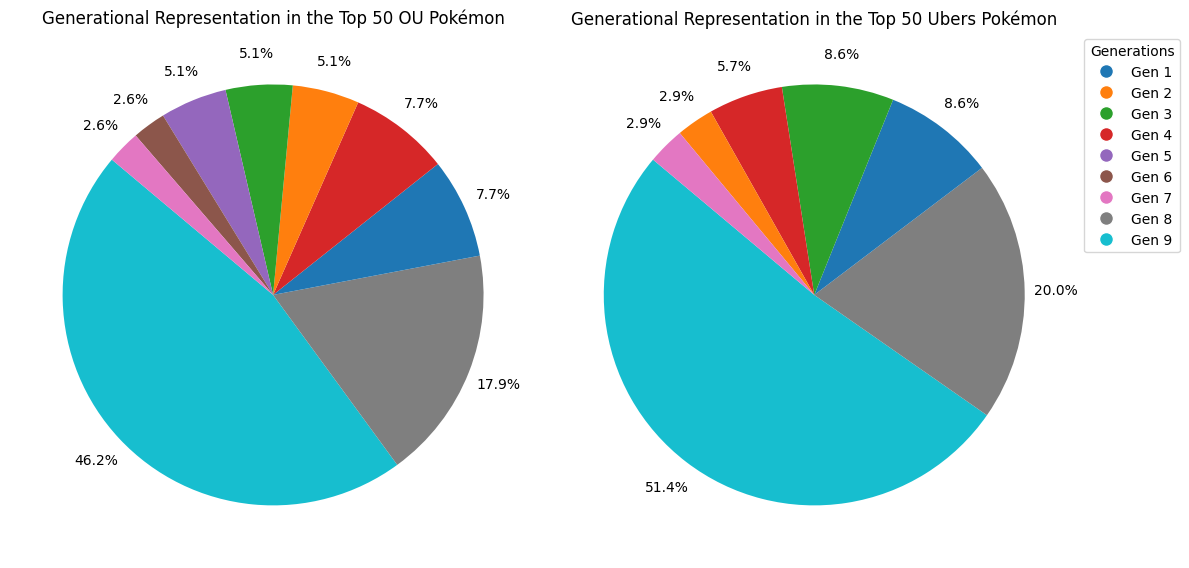

In [450]:
# open the txt Smogon file and read its contents, splitting it into lines
with open('smogon.com_stats_2023-08_gen9ou-1825.txt', 'r') as file:
    smogon_usage_OU = file.read().splitlines()

# initialize an empty list to store the parsed data
parsed_OU_data = []

# iterate through the lines and extract the ranking, name, and usage
for line in smogon_usage_OU:

    # split each line by '|' which are on the original text file
    elements = line.split('|')
    
    # check if the line contains data for a Pokémon (lines containing '| Rank |' are headers)
    # assign the corresponding info from each line
    if len(elements) >= 8:
        rank = elements[1].strip()
        pokemon_name = elements[2].strip()
        usage_percentage = elements[3].strip()
        
        # throw the parsed data in the list
        parsed_OU_data.append({
            'Rank': rank,
            'Pokemon': pokemon_name,
            'Usage %': usage_percentage,
        })

# same process used as the OU tier
with open('smogon.com_stats_2023-08_gen9ubers-1760.txt', 'r') as file:
    smogon_usage_ubers = file.read().splitlines()

# initialize an empty list to store the parsed data
parsed_ubers_data = []

# iterate through the lines and extract the ranking, name, and usage
for line in smogon_usage_ubers:
    
    # split each line by '|' which are on the original text file
    elements = line.split('|')
    
    # check if the line contains data for a Pokémon (lines containing '| Rank |' are headers)
    # assign the corresponding info from each line
    if len(elements) >= 8:
        rank = elements[1].strip()
        pokemon_name = elements[2].strip()
        usage_percentage = elements[3].strip()
        
        # throw the parsed data in the list
        parsed_ubers_data.append({
            'Rank': rank,
            'Pokemon': pokemon_name,
            'Usage %': usage_percentage,
        })

# use the parsed data from the OU and Uber tiers to compare back to the main dataframe to reference the generation of each Pokemon
# filter the top 50 ranked Pokémon for OU
top_50_OU = parsed_OU_data[:50]

# filter the top 50 ranked Pokémon for Ubers
top_50_Ubers = parsed_ubers_data[:50]





# define the colors so that both plots have consistent generation labels
master_generation_colors = {
    1: 'tab:blue',
    2: 'tab:orange',
    3: 'tab:green',
    4: 'tab:red',
    5: 'tab:purple',
    6: 'tab:brown',
    7: 'tab:pink',
    8: 'tab:gray',
    9: 'tab:cyan'
}

# create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# iterate over the tiers and data
for i, (tier_name, top_50_data, generation_colors) in enumerate([
    ('OU', top_50_OU, master_generation_colors),
    ('Ubers', top_50_Ubers, master_generation_colors)
]):

    # extract names of the top 50 Pokémon
    top_50_names = [entry['Pokemon'] for entry in top_50_data]

    # filter the pokedf to include only the top 50 Pokémon
    top_50_df = pokedf[pokedf['Name'].isin(top_50_names)]

    # count the number of Pokémon in each generation among the top 50
    generation_counts = top_50_df['Generation'].value_counts()

    # create a pie chart for each tier
    axs[i].pie(
        generation_counts,
        autopct = '%1.1f%%',
        startangle = 140,
        colors = [generation_colors[gen] for gen in generation_counts.index],
        pctdistance = 1.15
    )
    axs[i].set_title(f'Generational Representation in the Top 50 {tier_name} Pokémon')


# putting the legend in the second plot only since both plots use the same colors for different gens
legend_items = [plt.Line2D([0], [0], marker = 'o', color = 'w', label = f'Gen {gen}', markerfacecolor = color, markersize = 10) 
                for gen, color in master_generation_colors.items()]

# add legend to second plot
axs[1].legend(handles = legend_items, title = 'Generations', loc = 'upper left', bbox_to_anchor = (1, 1))


# better layout
plt.tight_layout()
plt.show()


explain that there is clear evidence on powercreep because of the ratios here

### **Stat Distributions**

#### Generational Averages and Medians

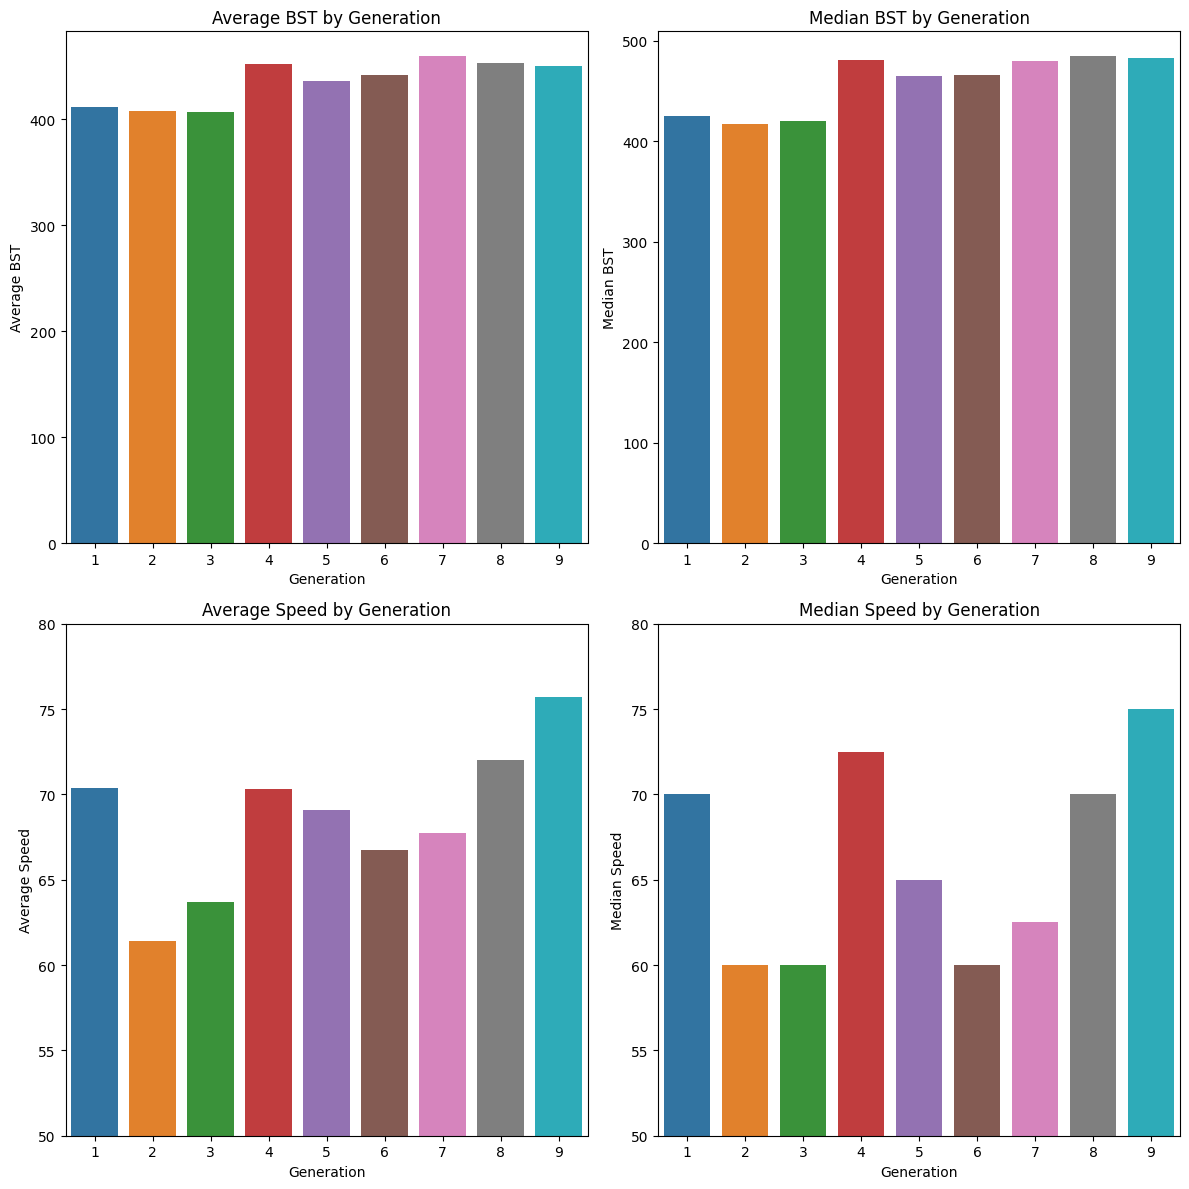

In [451]:
# define generation colors, all graphs in this notebook will use the same colors
master_generation_colors = {
    1: 'tab:blue',
    2: 'tab:orange',
    3: 'tab:green',
    4: 'tab:red',
    5: 'tab:purple',
    6: 'tab:brown',
    7: 'tab:pink',
    8: 'tab:gray',
    9: 'tab:cyan'
}

# create a figure with a 2x2 grid to display all subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# plot the average BST by generation on the first subplot
sns.barplot(x='Generation', y='BST', errorbar=None, data=pokedf, ax=axes[0, 0], palette=master_generation_colors.values())
axes[0, 0].set_title("Average BST by Generation")
axes[0, 0].set_xlabel("Generation")
axes[0, 0].set_ylabel("Average BST")

# plot the average Speed by generation on the second subplot
# y-axis is limited because even a small speed difference makes a large difference in a Pokemon's power
# speed margin doesn't matter when deciding who moves first, so essentially losing in speed in a 5 vs 100 scenario is equally as bad as losing in speed in a 99 vs 100 scenario
sns.barplot(x='Generation', y='Speed', errorbar=None, data=pokedf, ax=axes[1, 0], palette=master_generation_colors.values())
axes[1, 0].set_title("Average Speed by Generation")
axes[1, 0].set_xlabel("Generation")
axes[1, 0].set_ylabel("Average Speed")
axes[1, 0].set_ylim(50, 80)

# plot the median BST by generation on the third subplot
sns.barplot(x='Generation', y='BST', estimator=np.median, errorbar=None, data=pokedf, ax=axes[0, 1], palette=master_generation_colors.values())
axes[0, 1].set_title("Median BST by Generation")
axes[0, 1].set_xlabel("Generation")
axes[0, 1].set_ylabel("Median BST")

# plot the median Speed by generation on the fourth subplot
# same reasoning with the y-axis limits here
sns.barplot(x='Generation', y='Speed', estimator=np.median, errorbar=None, data=pokedf, ax=axes[1, 1], palette=master_generation_colors.values())
axes[1, 1].set_title("Median Speed by Generation")
axes[1, 1].set_xlabel("Generation")
axes[1, 1].set_ylabel("Median Speed")
axes[1, 1].set_ylim(50, 80)

# better layout
plt.tight_layout()
plt.show()


One of the most general (but not comprehensive) ways to check for the strength of a Pokemon is by checking their aptly named *Base Stat Total*, or BST. Athough the distribution of base stats matters just as much, generally, Pokemon with a higher BST tend to be stronger overall. Error bars were removed from the graph as since all Pokemon are in the dataset, there is no error.

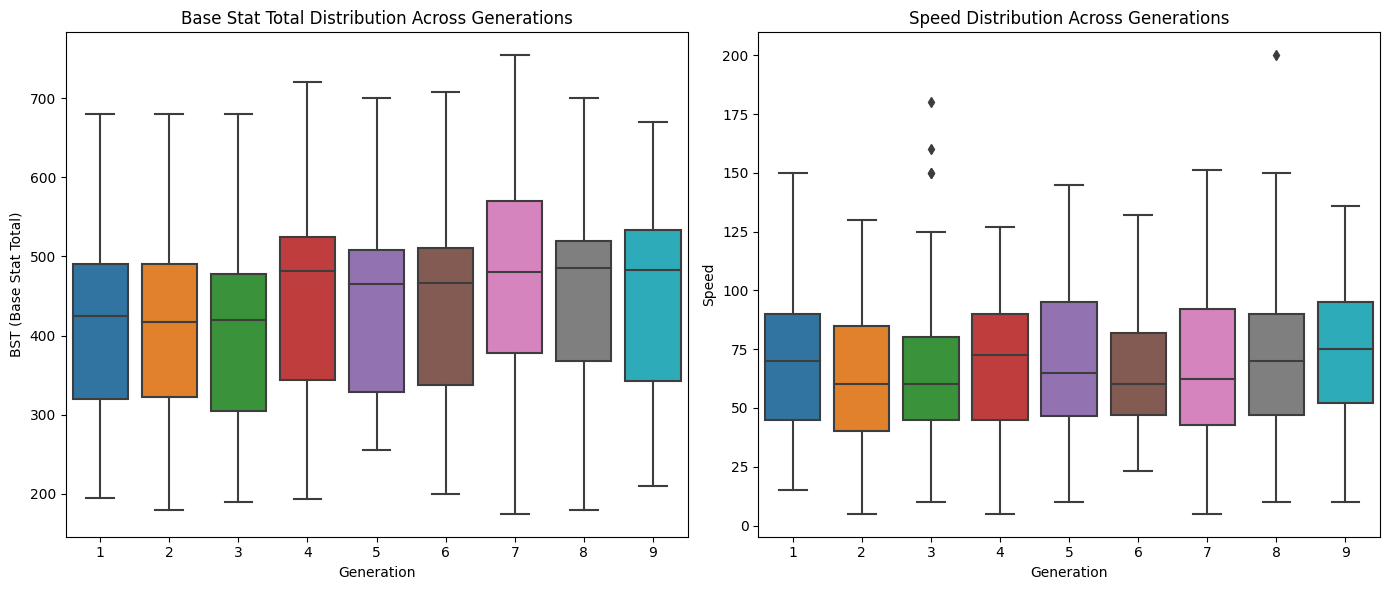

In [468]:
plt.figure(figsize = (14, 6))

# subplot 1: BST distribution
plt.subplot(1, 2, 1)
sns.boxplot(data = pokedf, x = 'Generation', y = 'BST', palette = master_generation_colors)
plt.xlabel('Generation')
plt.ylabel('BST (Base Stat Total)')
plt.title('Base Stat Total Distribution Across Generations')

# subplot 2: Speed distribution
plt.subplot(1, 2, 2)
sns.boxplot(data = pokedf, x = 'Generation', y = 'Speed', palette = master_generation_colors)
plt.xlabel('Generation')
plt.ylabel('Speed')
plt.title('Speed Distribution Across Generations')

# better spacing
plt.tight_layout()
plt.show()


There is a noticable uptick in speed in the newest generation, generation 9.

### **Type Strength**

Pokemon come in different types. Some Pokemon have only one type, called *monotypes*. Others have two types, known as *dual typing* Pokemon. 

#### Offensive

In [452]:
# rank types by offensive strength
# possibly a heat map with the sum of offensive typing advantage as the color

poke_typechart = pd.read_csv('poke_type_chart.csv', index_col = 0)

# the offensive type ranking combinations will be ranked by the total number of types that it is super effective against
offensive_strength = {}
for index, row in poke_typechart.iterrows():
    strength = sum(1 for value in row.values if value > 1.0)
    offensive_strength[index] = strength

# rank the offensive types in order
print(dict(sorted(offensive_strength.items(), key=lambda x: x[1], reverse=True)))



{'Fighting': 5, 'Ground': 5, 'Fire': 4, 'Ice': 4, 'Rock': 4, 'Water': 3, 'Grass': 3, 'Flying': 3, 'Bug': 3, 'Steel': 3, 'Fairy': 3, 'Electric': 2, 'Poison': 2, 'Psychic': 2, 'Ghost': 2, 'Dark': 2, 'Dragon': 1, 'Normal': 0}


#### Defensive

In [453]:
# opposite of offensive, almost same procedure
# we add a point for having a resistance and take away a point for having a weakness
# immunities are three points
defensive_strength = {}
for column in poke_typechart.columns:
    strength = 0
    for value in poke_typechart[column]:
        if value < 1.0:
            strength += 1
        elif value > 1.0:
            strength -= 1
        elif value == 0:
            strength += 3
    defensive_strength[column] = strength

print(dict(sorted(defensive_strength.items(), key=lambda x: x[1], reverse=True)))

{'Steel': 8, 'Fire': 3, 'Poison': 3, 'Water': 2, 'Electric': 2, 'Ghost': 2, 'Fairy': 2, 'Flying': 1, 'Dragon': 1, 'Normal': 0, 'Fighting': 0, 'Ground': 0, 'Bug': 0, 'Dark': 0, 'Grass': -1, 'Psychic': -1, 'Rock': -1, 'Ice': -3}


### **Special Pokemon**

#### Legendaries

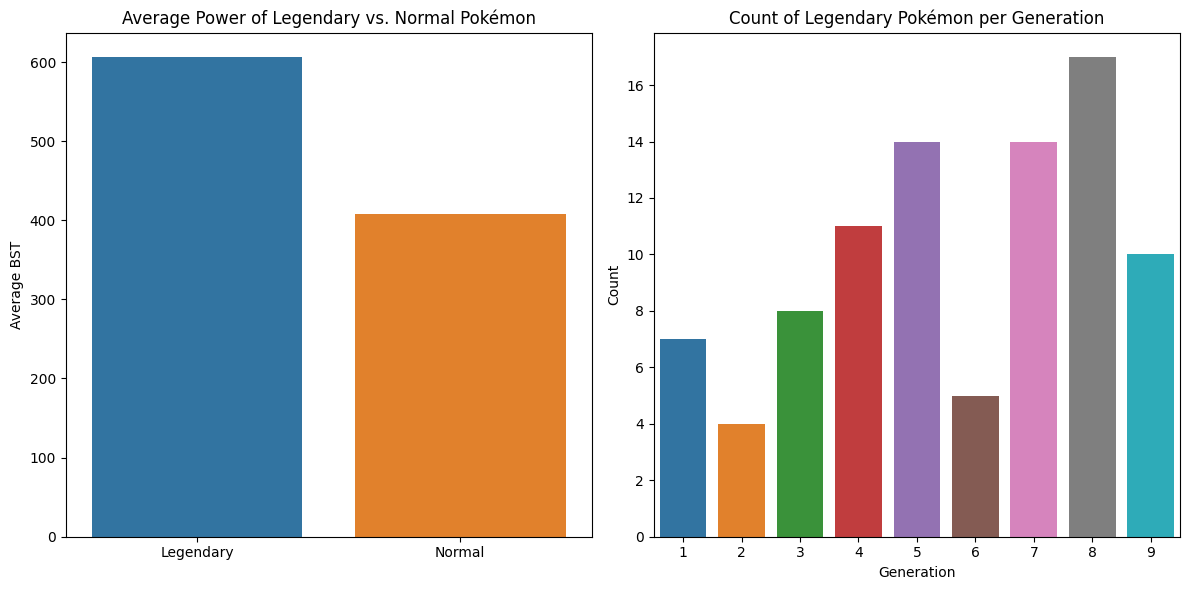

In [454]:
# calculate the average power of legendary vs non legendaries
legendary_avg_power = pokedf[pokedf['Legendary'] == True]['BST'].mean()
normal_avg_power = pokedf[(pokedf['Legendary'] == False) & 
                                (pokedf['Mythical'] == False) & 
                                (pokedf['Notable'] == False)]['BST'].mean()

# count the number of legendary pokemon per generation
legendary_per_generation = pokedf[pokedf['Legendary'] == True]['Generation'].value_counts().sort_index()

# create subplots
fig, axs = plt.subplots(1, 2, figsize = (12, 6))

# plot the average power comparison
sns.barplot(x = ['Legendary', 'Normal'], y = [legendary_avg_power, normal_avg_power], ax = axs[0])
axs[0].set_title('Average Power of Legendary vs. Normal Pokémon')
axs[0].set_ylabel('Average BST')

# plot the count of legendary pokemon, using the standard colors ofc
sns.barplot(x = legendary_per_generation.index, y = legendary_per_generation.values, ax = axs[1],
            palette = [master_generation_colors[gen] for gen in legendary_per_generation.index])
axs[1].set_title('Count of Legendary Pokémon per Generation')
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Count')

# better layout
plt.tight_layout()
plt.show()



#### Mythicals

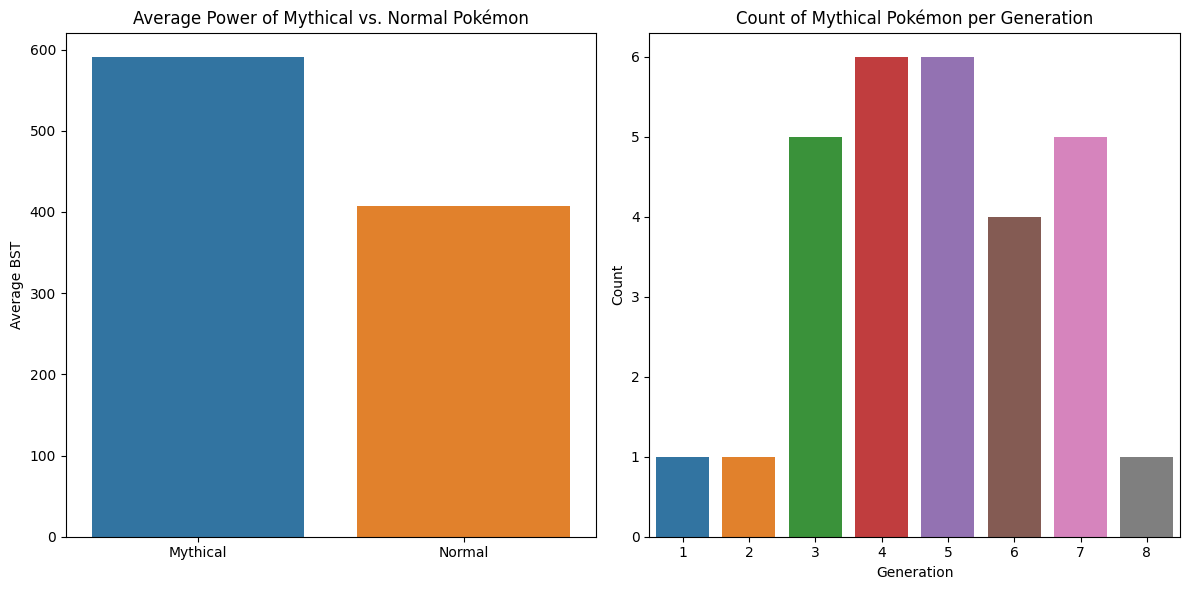

In [455]:
# basically same as legendaries
# one caveat is that they are usually restricted pokemon that arent allowed to be played, but for curiosities sake we might as well look at them

# calculate the average power of mythicals
mythical_avg_power = pokedf[pokedf['Mythical'] == True]['BST'].mean()

# count the number of mythical pokemon per generation
mythical_per_generation = pokedf[pokedf['Mythical'] == True]['Generation'].value_counts().sort_index()

# create subplots
fig, axs = plt.subplots(1, 2, figsize = (12, 6))

# plot the average power comparison
sns.barplot(x = ['Mythical', 'Normal'], y = [mythical_avg_power, normal_avg_power], ax = axs[0])
axs[0].set_title('Average Power of Mythical vs. Normal Pokémon')
axs[0].set_ylabel('Average BST')

# plot the count of mythical pokemon, using the standard colors ofc
sns.barplot(x = mythical_per_generation.index, y = mythical_per_generation.values, ax = axs[1],
            palette = [master_generation_colors[gen] for gen in mythical_per_generation.index])
axs[1].set_title('Count of Mythical Pokémon per Generation')
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Count')

# better layout
plt.tight_layout()
plt.show()


#### Notables

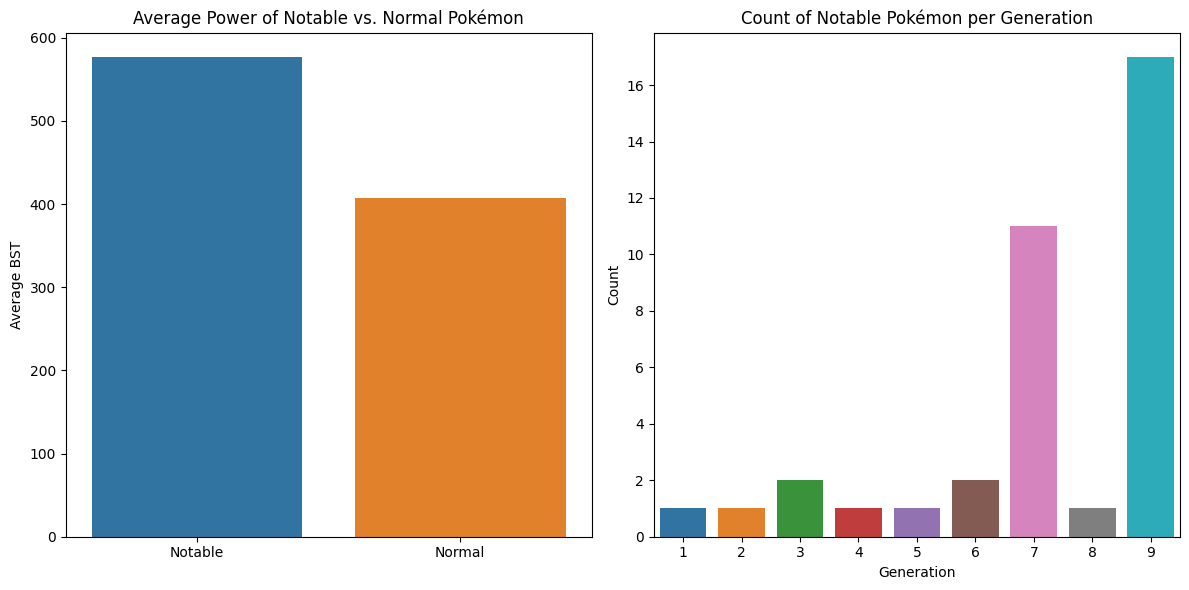

In [456]:
# handle this one a different way

# calculate the average power of mythicals
notable_avg_power = pokedf[pokedf['Notable'] == True]['BST'].mean()

# count the number of notable pokemon per generation
notable_per_generation = pokedf[pokedf['Notable'] == True]['Generation'].value_counts().sort_index()

# create subplots
fig, axs = plt.subplots(1, 2, figsize = (12, 6))

# plot the average power comparison
sns.barplot(x = ['Notable', 'Normal'], y = [notable_avg_power, normal_avg_power], ax = axs[0])
axs[0].set_title('Average Power of Notable vs. Normal Pokémon')
axs[0].set_ylabel('Average BST')

# plot the count of legendary pokemon, using the standard colors ofc
sns.barplot(x = notable_per_generation.index, y = notable_per_generation.values, ax = axs[1],
            palette = [master_generation_colors[gen] for gen in notable_per_generation.index])
axs[1].set_title('Count of Notable Pokémon per Generation')
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Count')

# better layout
plt.tight_layout()
plt.show()

#### 'Optimized' Pokemon

explanation of the concept of min/maxed pokemon

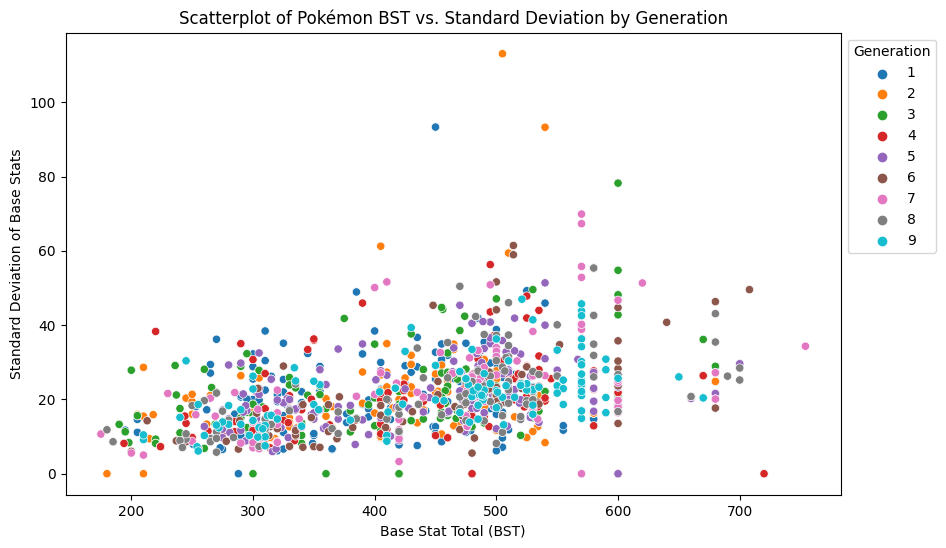

In [457]:
# make a scatterplot or a similar graph of all pokemon with bst on x and standard deviation on y and color them by generation

# calculate the standard deviation of the 6 base stats for each pokemon
pokedf['StdDev'] = pokedf[['HP', 'Attack', 'Defense', 'Sp. Attack', 'Sp. Defense', 'Speed']].std(axis=1)

# create a scatterplot with colors by gen
plt.figure(figsize = (10, 6))
sns.scatterplot(data = pokedf, x = 'BST', y = 'StdDev', hue = 'Generation', palette = master_generation_colors)

# set plot labels and title
plt.xlabel('Base Stat Total (BST)')
plt.ylabel('Standard Deviation of Base Stats')
plt.title('Scatterplot of Pokémon BST vs. Standard Deviation by Generation')

# show legend
plt.legend(title = 'Generation', loc = 'upper left', bbox_to_anchor = (1, 1))
plt.show()

Clearly there is no obvious gap in standard deviation in stats over the whole generation. Perhaps we find a more specific way to check for 'optimized' Pokemon.

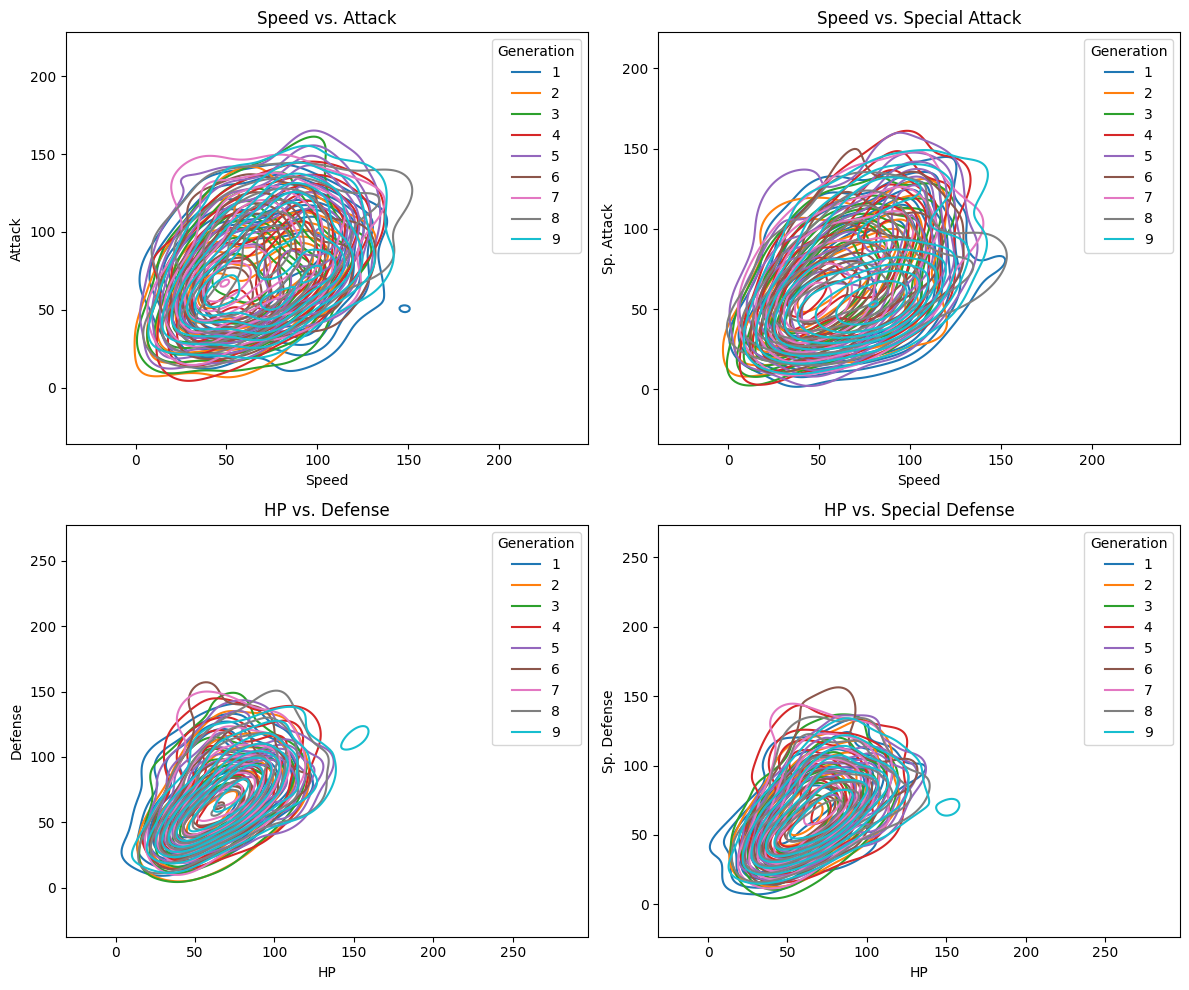

In [458]:
# subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# plot 1: Speed vs Attack
sns.kdeplot(
    data = pokedf,
    x = "Speed",
    y = "Attack",
    hue = "Generation",
    thresh = .1,
    palette = master_generation_colors,
    ax = axs[0, 0]
)
axs[0, 0].set_title("Speed vs. Attack")

# plot 2: Speed vs Sp Attack
sns.kdeplot(
    data = pokedf,
    x = "Speed",
    y = "Sp. Attack",
    hue = "Generation",
    thresh = .1,
    palette = master_generation_colors,
    ax = axs[0, 1]
)
axs[0, 1].set_title("Speed vs. Special Attack")

# plot 3: HP vs Defense
sns.kdeplot(
    data = pokedf,
    x = "HP",
    y = "Defense",
    hue = "Generation",
    thresh = .1,
    palette = master_generation_colors,
    ax = axs[1, 0]
)
axs[1, 0].set_title("HP vs. Defense")

# plot 4: HP vs Sp Defense
sns.kdeplot(
    data = pokedf,
    x = "HP",
    y = "Sp. Defense",
    hue = "Generation",
    thresh = .1,
    palette = master_generation_colors,
    ax = axs[1, 1]
)
axs[1, 1].set_title("HP vs. Special Defense")

# Adjust layout
plt.tight_layout()

# Show the subplots
plt.show()


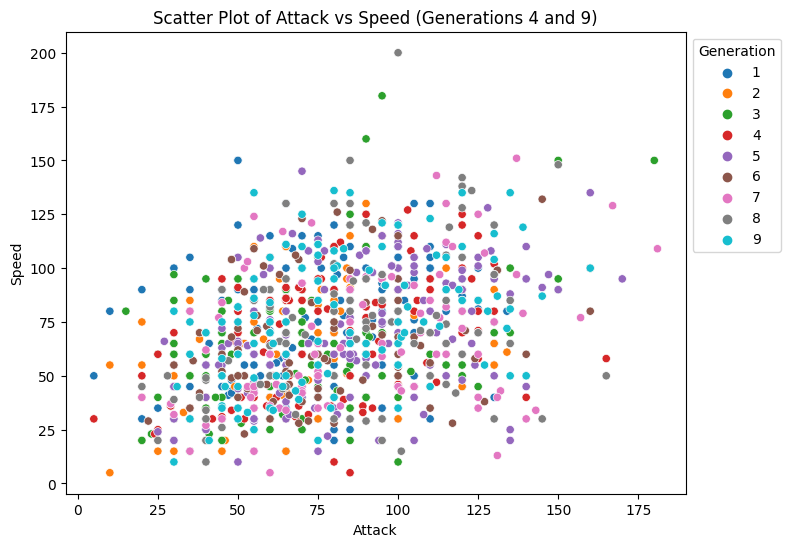

In [459]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pokedf, 
                x='Attack', 
                y='Speed', 
                hue='Generation', 
                palette=master_generation_colors)
plt.xlabel('Attack')
plt.ylabel('Speed')
plt.title('Scatter Plot of Attack vs Speed (Generations 4 and 9)')
plt.legend(title='Generation', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


In [462]:
# smogon top 50 std

## <h1 style="text-align: center;">Conclusions</h1>